# 深度神经网络应用--图像分类

完成此作业后，你将完成第4周最后的编程任务，也是本课程最后的编程任务！

你将使用在上一个作业中实现的函数来构建深层网络，并将其应用于分类cat图像和非cat图像。 希望你会看到相对于先前的逻辑回归实现的分类，准确性有所提高。

**完成此任务后，你将能够：**
- 建立深度神经网络并将其应用于监督学习。

让我们开始吧！

## 1 安装包

让我们首先导入在作业过程中需要的所有软件包。
- [numpy](www.numpy.org)是Python科学计算的基本包。
- [matplotlib](http://matplotlib.org) 是在Python中常用的绘制图形的库。
- [h5py](http://www.h5py.org)是一个常用的包，可以处理存储为H5文件格式的数据集
- 这里最后通过[PIL](http://www.pythonware.com/products/pil/)和 [scipy](https://www.scipy.org/)用你自己的图片去测试模型效果。
- dnn_app_utils提供了上一作业教程“逐步构建你的深度神经网络”中实现的函数。
- np.random.seed（1）使所有随机函数调用保持一致。 这将有助于我们评估你的作业。

In [1]:
cd ../data/L1W4

G:\deep learning\deeplearning.ai\data\L1W4


In [2]:
import time
import numpy as np
import h5py
import matplotlib.pyplot as plt
import scipy
from PIL import Image
from scipy import ndimage
from dnn_app_utils_v2 import *

%matplotlib inline
plt.rcParams['figure.figsize'] = (5.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

np.random.seed(1)

## 2 数据集

你将使用与“用神经网络思想实现Logistic回归”（作业2）中相同的“cats vs non-cats”数据集。 此前你建立的模型在对猫和非猫图像进行分类时只有70％的准确率。 希望你的新模型会更好！

**问题说明**：你将获得一个包含以下内容的数据集（"data.h5"）：
     - 标记为cat（1）和非cat（0）图像的训练集**m_train**
     - 标记为cat或non-cat图像的测试集**m_test**
     - 每个图像的维度都为（num_px，num_px，3），其中3表示3个通道（RGB）。

让我们熟悉一下数据集吧， 首先通过运行以下代码来加载数据。

In [3]:
train_x_orig, train_y, test_x_orig, test_y, classes = load_data()

运行以下代码以展示数据集中的图像。 通过更改索引，然后重新运行单元以查看其他图像。

y = 0. It's a non-cat picture.


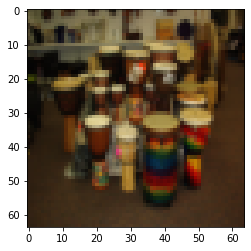

In [4]:
# Example of a picture
index = 5
plt.imshow(train_x_orig[index])
print ("y = " + str(train_y[0,index]) + ". It's a " + classes[train_y[0,index]].decode("utf-8") +  " picture.")

In [5]:
# Explore your dataset 
m_train = train_x_orig.shape[0]
num_px = train_x_orig.shape[1]
m_test = test_x_orig.shape[0]

print ("Number of training examples: " + str(m_train))
print ("Number of testing examples: " + str(m_test))
print ("Each image is of size: (" + str(num_px) + ", " + str(num_px) + ", 3)")
print ("train_x_orig shape: " + str(train_x_orig.shape))
print ("train_y shape: " + str(train_y.shape))
print ("test_x_orig shape: " + str(test_x_orig.shape))
print ("test_y shape: " + str(test_y.shape))

Number of training examples: 209
Number of testing examples: 50
Each image is of size: (64, 64, 3)
train_x_orig shape: (209, 64, 64, 3)
train_y shape: (1, 209)
test_x_orig shape: (50, 64, 64, 3)
test_y shape: (1, 50)


与往常一样，在将图像输入到网络之前，需要对图像进行重塑和标准化。 下面单元格给出了相关代码。

![Image Name](../image/L1W1/1.png)

图1：图像转换为向量。

In [6]:
# Reshape the training and test examples 
train_x_flatten = train_x_orig.reshape(train_x_orig.shape[0], -1).T   # The "-1" makes reshape flatten the remaining dimensions
test_x_flatten = test_x_orig.reshape(test_x_orig.shape[0], -1).T

# Standardize data to have feature values between 0 and 1.
train_x = train_x_flatten/255.
test_x = test_x_flatten/255.

print ("train_x's shape: " + str(train_x.shape))
print ("test_x's shape: " + str(test_x.shape))


train_x's shape: (12288, 209)
test_x's shape: (12288, 50)


$12,288$ 等于 $64 \times 64 \times 3$，这是图像重塑为向量的大小。

## 3 模型的结构

现在你已经熟悉了数据集，是时候建立一个深度神经网络来区分猫图像和非猫图像了。

你将建立两个不同的模型：
- 2层神经网络
- L层深度神经网络

然后，你将比较这些模型的性能，并尝试不同的$L$值。

让我们看一下两种架构。

### 3.1 2层神经网络

![Image Name](../image/L1W2/1.png)

图2：2层神经网络。

该模型可以总结为：***INPUT -> LINEAR -> RELU -> LINEAR -> SIGMOID -> OUTPUT***

图2的详细架构：
- 输入维度为（64,64,3）的图像，将其展平为大小为$（12288,1）$的向量。
- 相应的向量：$[x_0,x_1,...,x_{12287}]^T$乘以大小为$(n^{[1]}, 12288)$的权重矩阵$W^{[1]}$。
- 然后添加一个偏差项并按照公式获得以下向量：$[a_0^{[1]}, a_1^{[1]},..., a_{n^{[1]}-1}^{[1]}]^T$。
- 然后，重复相同的过程。
- 将所得向量乘以$W^{[2]}$并加上截距（偏差）。
- 最后，采用结果的sigmoid值。 如果大于0.5，则将其分类为猫。

### 3.2 L层深度神经网络

用上面的方式很难表示一个L层的深度神经网络。 这是一个简化的网络表示形式：

![Image Name](../image/L1W4/6.png)

图3：L层神经网络。
该模型可以总结为：***[LINEAR -> RELU] $\times$ (L-1) -> LINEAR -> SIGMOID***

图3的详细结构：
- 输入维度为（64,64,3）的图像，将其展平为大小为$（12288,1）$的向量。
- 相应的向量：$[x_0,x_1,...,x_{12287}]^T$乘以权重矩阵$W^{[1]}$，然后加上截距$b^{[1]}$，结果为线性单位。
- 接下来计算获得的线性单元。对于每个$(W^{[l]}, b^{[l]})$，可以重复数次，具体取决于模型体系结构。
- 最后，采用最终线性单位的sigmoid值。如果大于0.5，则将其分类为猫。

### 3.3 通用步骤

与往常一样，你将遵循深度学习步骤来构建模型：
    1.初始化参数/定义超参数
    2.循环num_iterations次：
        a. 正向传播
        b. 计算损失函数
        C. 反向传播
        d. 更新参数（使用参数和反向传播的梯度）
    4.使用训练好的参数来预测标签

现在让我们实现这两个模型！

## 4 两层神经网络

**问题**：使用你在上一个作业中实现的辅助函数来构建具有以下结构的2层神经网络：*LINEAR -> RELU -> LINEAR -> SIGMOID*，你可能需要的函数及其输入为：

```python
def initialize_parameters(n_x, n_h, n_y):
    ...
    return parameters 
def linear_activation_forward(A_prev, W, b, activation):
    ...
    return A, cache
def compute_cost(AL, Y):
    ...
    return cost
def linear_activation_backward(dA, cache, activation):
    ...
    return dA_prev, dW, db
def update_parameters(parameters, grads, learning_rate):
    ...
    return parameters
```

In [10]:
### CONSTANTS DEFINING THE MODEL ####
n_x = 12288     # num_px * num_px * 3
n_h = 7
n_y = 1
layers_dims = (n_x, n_h, n_y)

In [11]:
# GRADED FUNCTION: two_layer_model

def two_layer_model(X, Y, layers_dims, learning_rate = 0.0075, num_iterations = 3000, print_cost=False):
    """
    Implements a two-layer neural network: LINEAR->RELU->LINEAR->SIGMOID.
    
    Arguments:
    X -- input data, of shape (n_x, number of examples)
    Y -- true "label" vector (containing 0 if cat, 1 if non-cat), of shape (1, number of examples)
    layers_dims -- dimensions of the layers (n_x, n_h, n_y)
    num_iterations -- number of iterations of the optimization loop
    learning_rate -- learning rate of the gradient descent update rule
    print_cost -- If set to True, this will print the cost every 100 iterations 
    
    Returns:
    parameters -- a dictionary containing W1, W2, b1, and b2
    """
    
    np.random.seed(1)
    grads = {}
    costs = []                              # to keep track of the cost
    m = X.shape[1]                           # number of examples
    (n_x, n_h, n_y) = layers_dims
    
    # Initialize parameters dictionary, by calling one of the functions you'd previously implemented
    ### START CODE HERE ### (≈ 1 line of code)
    parameters = initialize_parameters(n_x, n_h, n_y)
    ### END CODE HERE ###
    
    # Get W1, b1, W2 and b2 from the dictionary parameters.
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]
    
    # Loop (gradient descent)

    for i in range(0, num_iterations):

        # Forward propagation: LINEAR -> RELU -> LINEAR -> SIGMOID. Inputs: "X, W1, b1". Output: "A1, cache1, A2, cache2".
        ### START CODE HERE ### (≈ 2 lines of code)
        A1, cache1 =linear_activation_forward(X, W1, b1, activation = "relu")
        A2, cache2 = linear_activation_forward(A1, W2, b2, activation = "sigmoid")
        ### END CODE HERE ###
        
        # Compute cost
        ### START CODE HERE ### (≈ 1 line of code)
        cost = compute_cost(A2, Y)
        ### END CODE HERE ###
        
        # Initializing backward propagation
        dA2 = - (np.divide(Y, A2) - np.divide(1 - Y, 1 - A2))
        
        # Backward propagation. Inputs: "dA2, cache2, cache1". Outputs: "dA1, dW2, db2; also dA0 (not used), dW1, db1".
        ### START CODE HERE ### (≈ 2 lines of code)
        dA1, dW2, db2 = linear_activation_backward(dA2, cache2, activation = "sigmoid")
        dA0, dW1, db1 = linear_activation_backward(dA1, cache1, activation = "relu")
        ### END CODE HERE ###
        
        # Set grads['dWl'] to dW1, grads['db1'] to db1, grads['dW2'] to dW2, grads['db2'] to db2
        grads['dW1'] = dW1
        grads['db1'] = db1
        grads['dW2'] = dW2
        grads['db2'] = db2
        
        # Update parameters.
        ### START CODE HERE ### (approx. 1 line of code)
        parameters = update_parameters(parameters, grads, learning_rate)
        ### END CODE HERE ###

        # Retrieve W1, b1, W2, b2 from parameters
        W1 = parameters["W1"]
        b1 = parameters["b1"]
        W2 = parameters["W2"]
        b2 = parameters["b2"]
        
        # Print the cost every 100 training example
        if print_cost and i % 100 == 0:
            print("Cost after iteration {}: {}".format(i, np.squeeze(cost)))
        if print_cost and i % 100 == 0:
            costs.append(cost)
       
    # plot the cost

    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per tens)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
    
    return parameters

运行下面的单元格以训练模型参数。观察损失下降以查看模型是否运行。运行2500次迭代可能最多需要5分钟。 检查“迭代0次后的损失”是否与下面的预期输出匹配。如果没有，单击笔记本上方栏上的正方形（⬛）以停止单元格并尝试查找错误。

Cost after iteration 0: 0.6930497356599888
Cost after iteration 100: 0.6464320953428849
Cost after iteration 200: 0.6325140647912677
Cost after iteration 300: 0.6015024920354665
Cost after iteration 400: 0.5601966311605747
Cost after iteration 500: 0.5158304772764729
Cost after iteration 600: 0.47549013139433255
Cost after iteration 700: 0.43391631512257495
Cost after iteration 800: 0.4007977536203886
Cost after iteration 900: 0.3580705011323798
Cost after iteration 1000: 0.3394281538366412
Cost after iteration 1100: 0.3052753636196264
Cost after iteration 1200: 0.2749137728213015
Cost after iteration 1300: 0.24681768210614846
Cost after iteration 1400: 0.19850735037466108
Cost after iteration 1500: 0.17448318112556654
Cost after iteration 1600: 0.17080762978096023
Cost after iteration 1700: 0.11306524562164728
Cost after iteration 1800: 0.09629426845937154
Cost after iteration 1900: 0.08342617959726861
Cost after iteration 2000: 0.07439078704319084
Cost after iteration 2100: 0.0663074

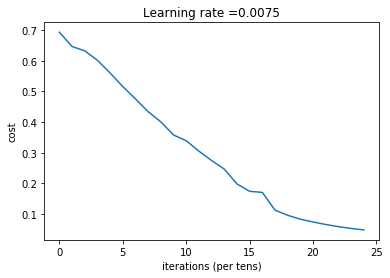

In [12]:
parameters = two_layer_model(train_x, train_y, layers_dims = (n_x, n_h, n_y), num_iterations = 2500, print_cost=True)

**预期输出**:
**0次迭代后的损失**：
0.6930497356599888
**100次迭代后的损失**：
0.6464320953428849
...
**2400次迭代后的损失**：
0.048554785628770206

你构建了向量化的实现！ 否则，可能需要花费10倍的时间来训练它。

你可以使用训练好的参数对数据集中的图像进行分类。 要查看训练和测试集的预测结果，请运行以下单元格。

In [13]:
predictions_train = predict(train_x, train_y, parameters)

Accuracy: 0.9999999999999998


**预期输出**:
Accuracy: 0.9999999999999998

In [14]:
predictions_test = predict(test_x, test_y, parameters)

Accuracy: 0.72


**预期输出**:
Accuracy: 0.72

**注意**：你可能会注意到，以较少的迭代次数（例如1500）运行模型可以使测试集具有更高的准确性。 这称为“尽早停止”，我们将在下一课程中讨论。 提前停止是防止过拟合的一种方法。

恭喜你！看来你的2层神经网络的性能（72％）比逻辑回归实现（70％，第2周的作业）更好。 让我们看看使用$L$层模型是否可以做得更好。

## 5 L层神经网络

**问题**：使用之前实现的辅助函数来构建具有以下结构的$L$层神经网络：*[LINEAR -> RELU]$\times$(L-1) -> LINEAR -> SIGMOID*。 你可能需要的函数及其输入为：

```python
def initialize_parameters_deep(layer_dims):
    ...
    return parameters 
def L_model_forward(X, parameters):
    ...
    return AL, caches
def compute_cost(AL, Y):
    ...
    return cost
def L_model_backward(AL, Y, caches):
    ...
    return grads
def update_parameters(parameters, grads, learning_rate):
    ...
    return parameters
```

In [7]:
### CONSTANTS ###
layers_dims = [12288, 20, 7, 5, 1] #  5-layer model

In [8]:
# GRADED FUNCTION: L_layer_model

def L_layer_model(X, Y, layers_dims, learning_rate = 0.0075, num_iterations = 3000, print_cost=False):#lr was 0.009
    """
    Implements a L-layer neural network: [LINEAR->RELU]*(L-1)->LINEAR->SIGMOID.
    
    Arguments:
    X -- data, numpy array of shape (number of examples, num_px * num_px * 3)
    Y -- true "label" vector (containing 0 if cat, 1 if non-cat), of shape (1, number of examples)
    layers_dims -- list containing the input size and each layer size, of length (number of layers + 1).
    learning_rate -- learning rate of the gradient descent update rule
    num_iterations -- number of iterations of the optimization loop
    print_cost -- if True, it prints the cost every 100 steps
    
    Returns:
    parameters -- parameters learnt by the model. They can then be used to predict.
    """

    np.random.seed(1)
    costs = []                         # keep track of cost
    
    # Parameters initialization.
    ### START CODE HERE ###
    parameters = initialize_parameters_deep(layers_dims)
    ### END CODE HERE ###
    
    # Loop (gradient descent)
    for i in range(0, num_iterations):

        # Forward propagation: [LINEAR -> RELU]*(L-1) -> LINEAR -> SIGMOID.
        ### START CODE HERE ### (≈ 1 line of code)
        AL, caches = L_model_forward(X, parameters)
        ### END CODE HERE ###
        
        # Compute cost.
        ### START CODE HERE ### (≈ 1 line of code)
        cost = compute_cost(AL, Y)
        ### END CODE HERE ###
    
        # Backward propagation.
        ### START CODE HERE ### (≈ 1 line of code)
        grads = L_model_backward(AL, Y, caches)
        ### END CODE HERE ###
 
        # Update parameters.
        ### START CODE HERE ### (≈ 1 line of code)
        parameters = update_parameters(parameters, grads, learning_rate)
        ### END CODE HERE ###
                
        # Print the cost every 100 training example
        if print_cost and i % 100 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))
        if print_cost and i % 100 == 0:
            costs.append(cost)
            
    # plot the cost
    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per tens)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
    
    return parameters

现在，你将训练5层的神经网络模型。

运行下面的单元格以训练你的模型。 每次迭代的损失都应该降低。 运行2500次迭代最多可能需要5分钟。 检查“迭代0次后的损失”是否与下面的预期输出匹配，如果没有单击笔记本上方的正方形（⬛）以停止单元格并尝试查找错误。

Cost after iteration 0: 0.771749
Cost after iteration 100: 0.672053
Cost after iteration 200: 0.648263
Cost after iteration 300: 0.611507
Cost after iteration 400: 0.567047
Cost after iteration 500: 0.540138
Cost after iteration 600: 0.527930
Cost after iteration 700: 0.465477
Cost after iteration 800: 0.369126
Cost after iteration 900: 0.391747
Cost after iteration 1000: 0.315187
Cost after iteration 1100: 0.272700
Cost after iteration 1200: 0.237419
Cost after iteration 1300: 0.199601
Cost after iteration 1400: 0.189263
Cost after iteration 1500: 0.161189
Cost after iteration 1600: 0.148214
Cost after iteration 1700: 0.137775
Cost after iteration 1800: 0.129740
Cost after iteration 1900: 0.121225
Cost after iteration 2000: 0.113821
Cost after iteration 2100: 0.107839
Cost after iteration 2200: 0.102855
Cost after iteration 2300: 0.100897
Cost after iteration 2400: 0.092878


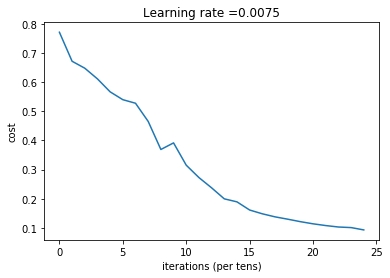

In [9]:
parameters = L_layer_model(train_x, train_y, layers_dims, num_iterations = 2500, print_cost = True)

**预期输出**:
**0次迭代后的损失**：
0.771749
**100次迭代后的损失**：
0.672053
...
**2400次迭代后的损失**：
0.092878

In [10]:
pred_train = predict(train_x, train_y, parameters)

Accuracy: 0.9856459330143539


**预期输出**:
Accuracy: 0.985645933014

In [11]:
pred_test = predict(test_x, test_y, parameters)

Accuracy: 0.8


**预期输出**:
Accuracy: 0.8

Congrats! It seems that your 5-layer neural network has better performance (80%) than your 2-layer neural network (72%) on the same test set. 

This is good performance for this task. Nice job! 

Though in the next course on "Improving deep neural networks" you will learn how to obtain even higher accuracy by systematically searching for better hyperparameters (learning_rate, layers_dims, num_iterations, and others you'll also learn in the next course). 

Good！在相同的测试集上，你的5层的神经网络似乎比2层神经网络具有更好的性能（80％）。做的好！

在下一作业教程“改善深度神经网络”中，你将学习如何通过系统地匹配更好的超参数（学习率，层数，迭代次数以及下一门课程中还将学习到的其他参数）来获得更高的准确性。

## 6 结果分析

首先，让我们看一下L层模型标记错误的一些图像。 这将显示一些分类错误的图像。

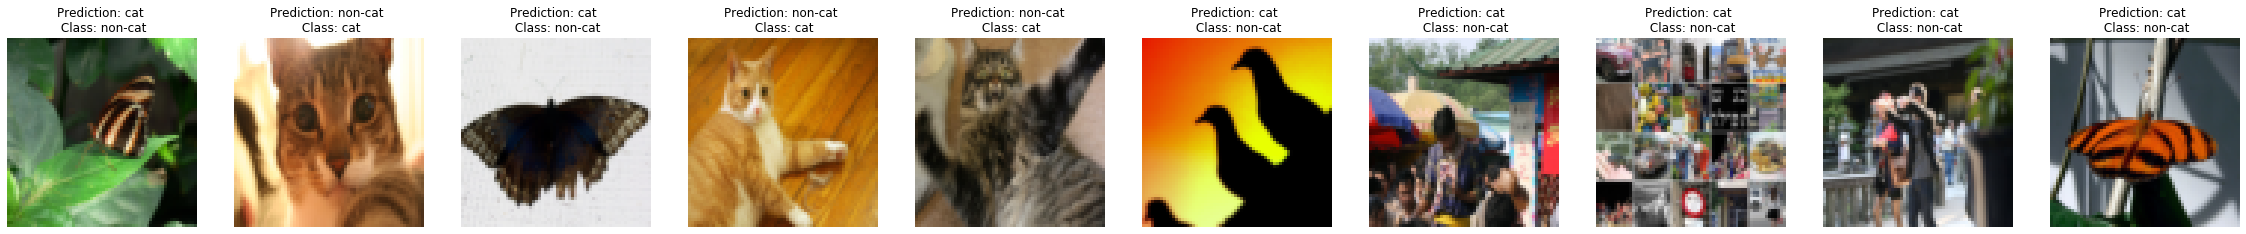

In [12]:
print_mislabeled_images(classes, test_x, test_y, pred_test)

**该模型在表现效果较差的的图像包括：**
- 猫身处于异常位置
- 图片背景与猫颜色类似
- 猫的种类和颜色稀有
- 相机角度
- 图片的亮度
- 比例变化（猫的图像很大或很小）

## 7 使用你自己的图像进行测试（可选练习）##

祝贺你完成此作业。 你可以使用自己的图像测试并查看模型的输出。要做到这一点：
     1.单击此笔记本上部栏中的“File”，然后单击“Open”以在Coursera Hub上运行。
     2.将图像添加到Jupyter Notebook的目录中，在“images”文件夹中
     3.在以下代码中更改图像的名称
     4.运行代码，检查算法是否正确（1 = cat，0 = non-cat）！

Accuracy: 0.0
y = 0.0, your L-layer model predicts a "non-cat" picture.


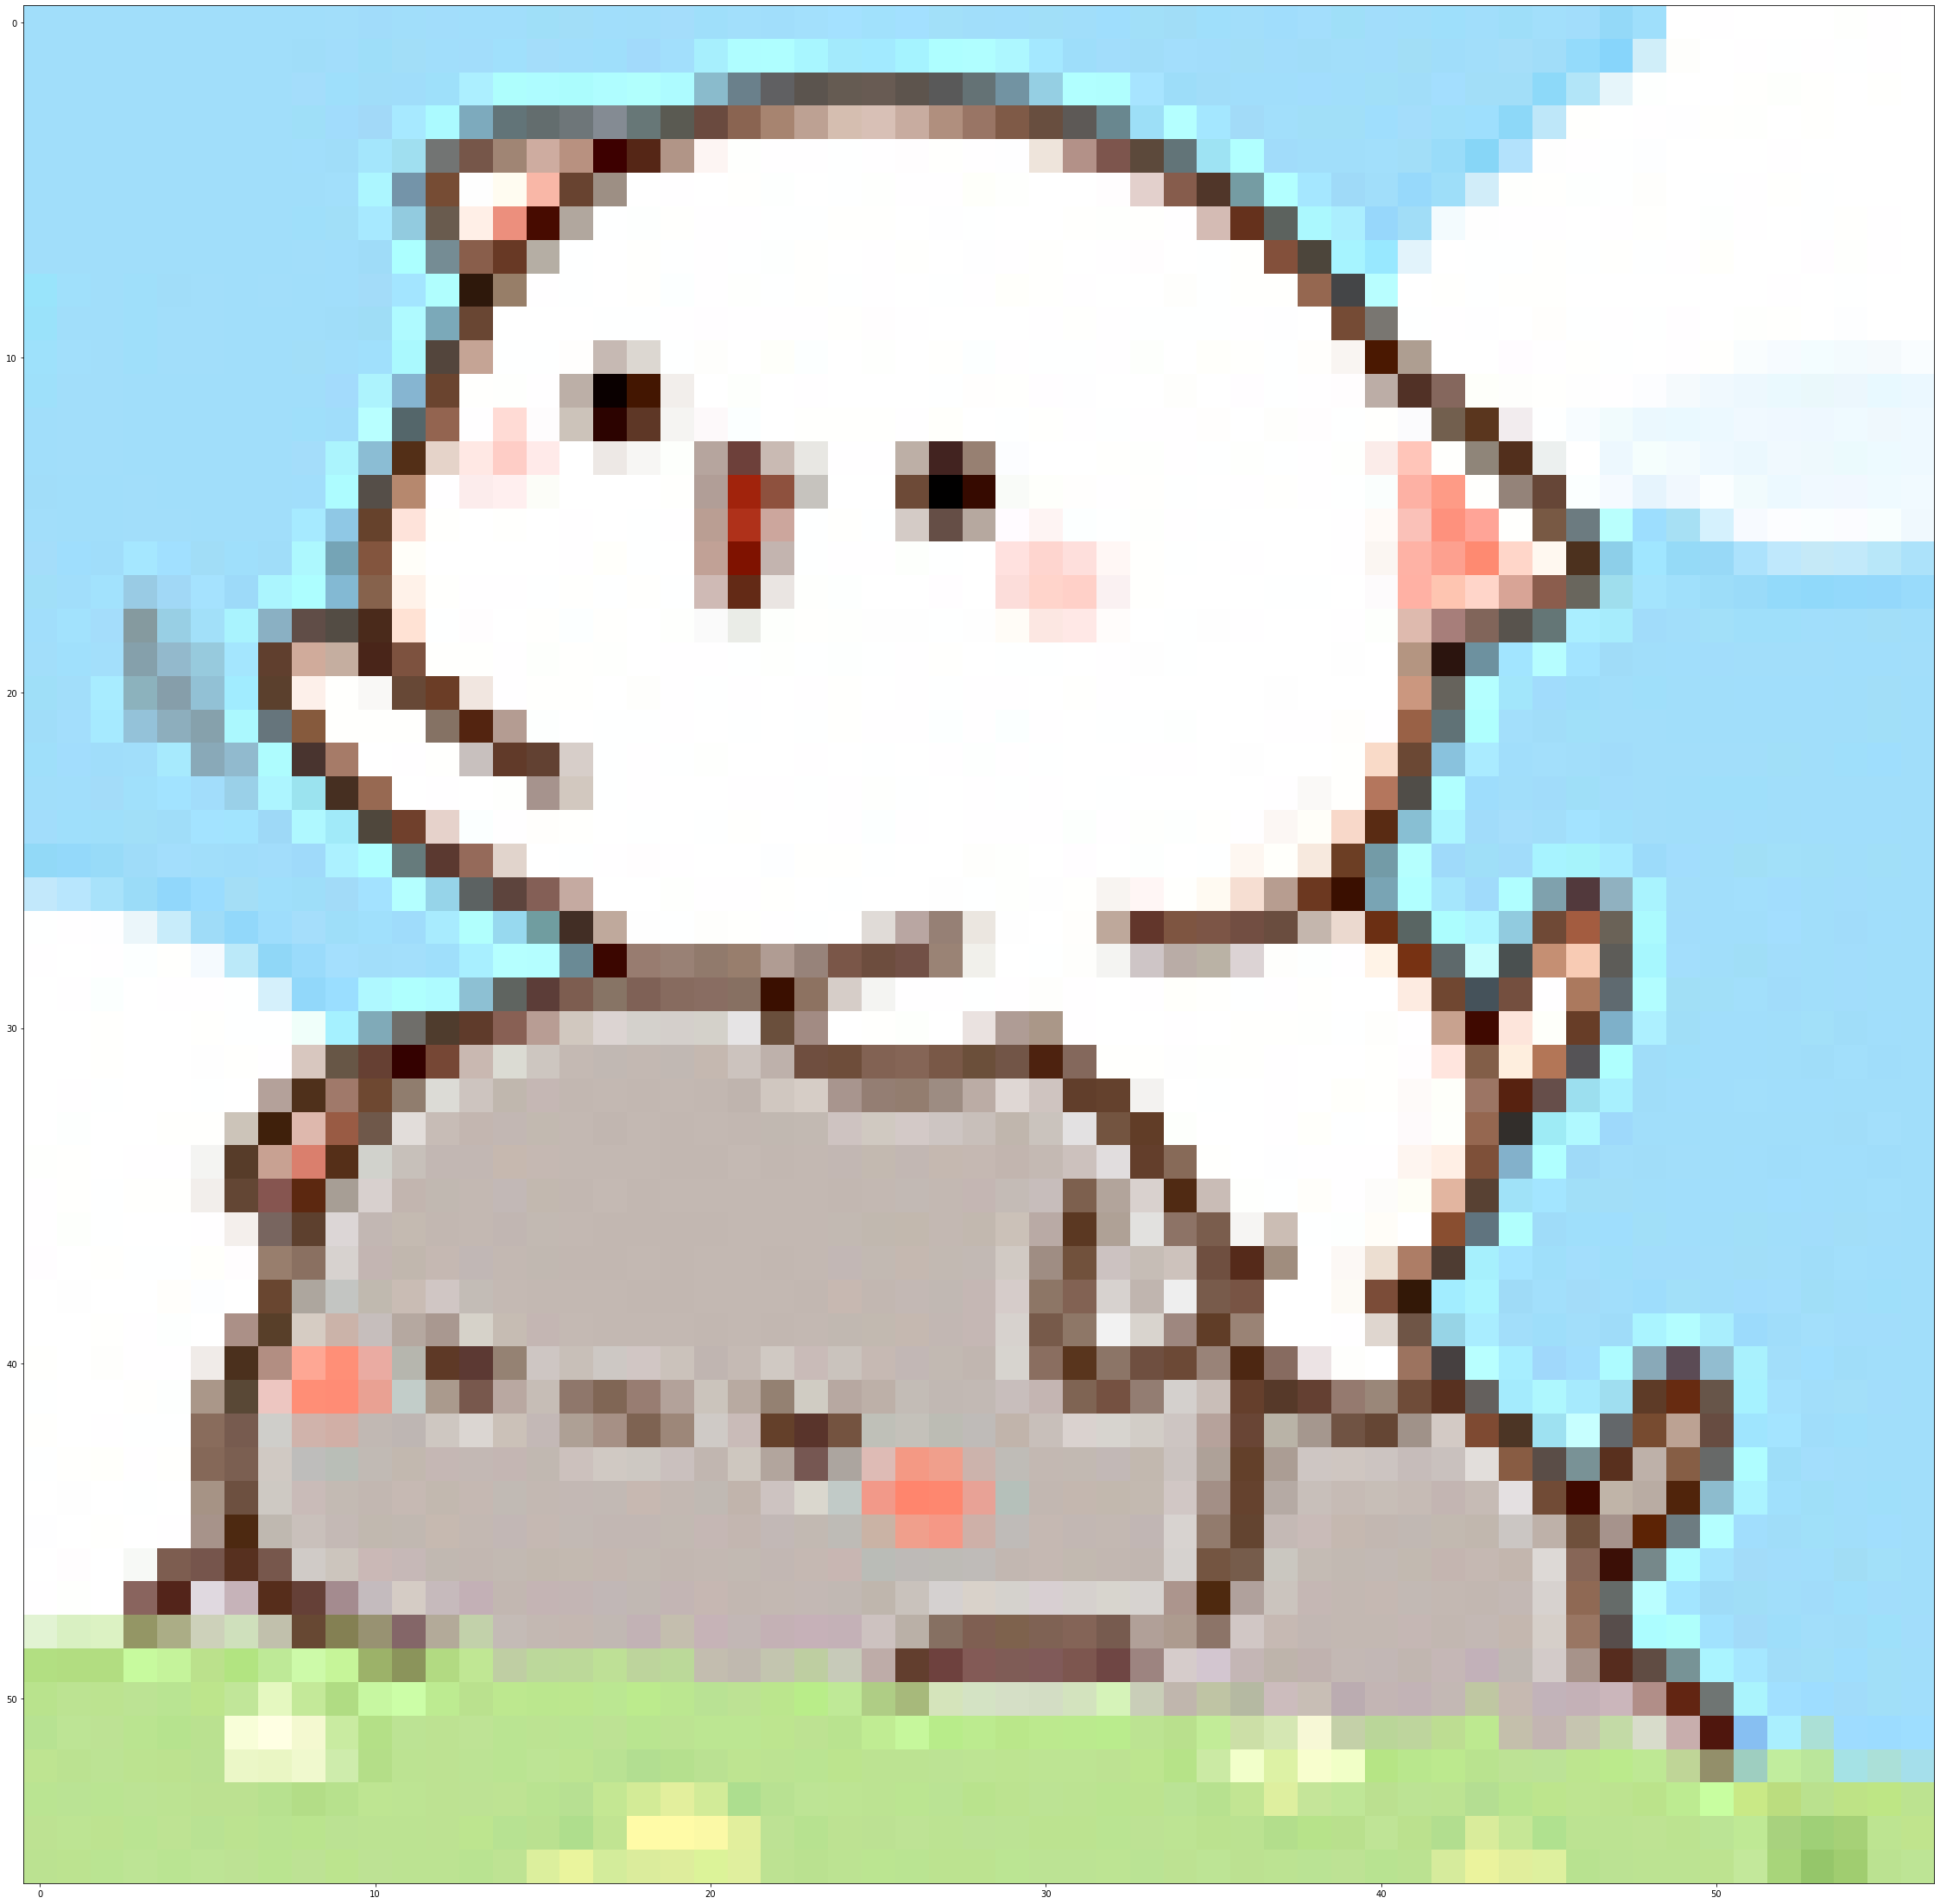

In [13]:
## START CODE HERE ##
my_image = "my_image.jpg" # change this to the name of your image file 
my_label_y = [1] # the true class of your image (1 -> cat, 0 -> non-cat)
## END CODE HERE ##

fname = my_image
image = np.array(plt.imread(fname))
my_image = np.array(Image.fromarray(image).resize(size=(num_px,num_px))).reshape((num_px*num_px*3,1))
my_predicted_image = predict(my_image, my_label_y, parameters)

plt.imshow(image)
print ("y = " + str(np.squeeze(my_predicted_image)) + ", your L-layer model predicts a \"" + classes[int(np.squeeze(my_predicted_image)),].decode("utf-8") +  "\" picture.")

**参考**：
- for auto-reloading external module: http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython